 <h1 style="text-align:center;">Analysis of the behavior of a team according to score by Romain Traboul</h1>
 
**Test statement**: Select a player(s) or team(s) and a topic of your choice and write a short analysis piece (~500 words) including some data visualisations.

**Database**: To carry out this test, open source Statsbomb data and the statsbombpy library can be used.

**Subject**: The subject is the visualization of key statistical indicators over a soccer season, in terms of whether a team is leading, drawing or being led. To do this, we'll use the 2015-2016 Ligue 1 season, and the team analyzed will be Rennes. These indicators will be displayed through 2 prisms : Rennes' statistics and the statistics of teams playing against Rennes. Please note that all statistics are reported at 90 minutes.

## <span style="color:orange">**Task 1 :**</span> Data extraction / Data pre-processing

To begin with, we're going to download the libraries needed for the project (this is in comments if it's already been done).

In [36]:
# Installation of libraries required for the project

#!pip install statsbombpy # Used to retrieve match data
#!pip install -U kaleido # Used to download pdf graphics

As a 1st step, we extract the events of the 2015-2016 Ligue 1 season, keeping the information that will be useful to us later.

In [37]:
# Importing libraries
from statsbombpy import sb
import pandas as pd
import os
from tqdm import tqdm
import warnings
from statsbombpy.api_client import NoAuthWarning

# Withdrawal of the warning informing us that we are using open data
warnings.filterwarnings("ignore", category=NoAuthWarning)

# Storage of competition name and season selected
competition_name = "Ligue 1"
season_name = "2015/2016"

# Columns to keep from Statsbomb match events
columns_to_keep = [
    'index', 'match_id', 'period', 'minute', 'second', 'player', 'team', 'possession',
    'possession_team', 'type', 'play_pattern', 'location', 'duel_type', 'duel_outcome',
    'duration','pass_outcome', 'shot_outcome', 'shot_statsbomb_xg'
]

# Event types to exclude from Statsbomb match events
types_to_exclude = [
    'Ball Receipt*', 'Half Start', 'Half End', 'Referee Ball-Drop', 'Injury Stoppage',
    'Tactical Shift', 'Starting XI', 'Player Off', 'Player On', 'Own Goal For',
    'Goal Keeper', 'Substitution', 'Dribbled Past'
]

# Creation of a function indicating whether there is a goal during the action
def map_outcome_goal(row):
    if row.get('shot_outcome') == 'Goal' or row.get('type') == 'Own Goal Against':
        return 1
    return 0

# Competition_id and season_id retrieval based on previously entered information (competition_name, season_name)
competitions_data = sb.competitions()
competition_id = competitions_data[competitions_data["competition_name"] == competition_name]["competition_id"].iloc[0]
season_id = competitions_data[competitions_data["season_name"] == season_name]["season_id"].iloc[0]

# Match retrieval
matches_data = sb.matches(competition_id=competition_id, season_id=season_id)

# Main folder
os.makedirs("data", exist_ok=True) 

# Processing each match with a progress bar
for _, match in tqdm(matches_data.iterrows(), total=len(matches_data), desc="Match processing"):
    
    # Retrieve information on the match identifier and the names of the two teams
    match_id = match['match_id']
    home_team = match['home_team']
    away_team = match['away_team']

    # Search for match events
    events_data = sb.events(match_id=match_id)

    # Filter columns
    available_columns = [col for col in columns_to_keep if col in events_data.columns]
    events_data = events_data[available_columns]

    # Filter unwanted types
    if 'type' in events_data.columns:
        events_data = events_data[~events_data['type'].isin(types_to_exclude)]

    # Sort by index if present
    if 'index' in events_data.columns:
        events_data = events_data.sort_values(by='index').reset_index(drop=True)

    # Add our column outcome_goal
    events_data['outcome_goal'] = events_data.apply(map_outcome_goal, axis=1)

    # Add location_x and location_y to separate this information
    events_data['location_x'] = events_data['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    events_data['location_y'] = events_data['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    # Add time_sec for single-column information on match time
    events_data['time_sec'] = events_data['minute'] * 60 + events_data['second']

    # Initialization of the match score for each event
    home_score_list = []
    away_score_list = []
    home_score = 0
    away_score = 0

    # Score update (in n+1)
    for i in range(len(events_data)):
        home_score_list.append(home_score)
        away_score_list.append(away_score)

        # Find the lines where there is a goal, the team with the ball and the type of action at that moment
        is_goal = events_data.loc[i, 'outcome_goal'] == 1
        possession_team = events_data.loc[i, 'possession_team']
        event_team = events_data.loc[i, 'team']
        event_type = events_data.loc[i, 'type']
        
        # Count the goal even if it's an own goal
        if is_goal:
            if possession_team == home_team or (event_type == 'Own Goal Against' and event_team == away_team):
                home_score += 1
            elif possession_team == away_team or (event_type == 'Own Goal Against' and event_team == home_team):
                away_score += 1

    events_data['home_score'] = home_score_list
    events_data['away_score'] = away_score_list

    # Add state_match according to match score
    def compute_state(row):
        if row['home_score'] > row['away_score']:
            return 'home_win'
        elif row['home_score'] < row['away_score']:
            return 'away_win'
        else:
            return 'draw'

    events_data['state_match'] = events_data.apply(compute_state, axis=1)

    # Column initialization of the number of seconds spent in each state
    events_data['time_sec_home_lead'] = 0
    events_data['time_sec_draw'] = 0
    events_data['time_sec_away_lead'] = 0

    # Counter initialization
    time_home = 0
    time_draw = 0
    time_away = 0

    # Iteration on DataFrame rows
    for i in range(1, len(events_data)):
        # Seconds countdown
        delta = events_data.loc[i, 'time_sec'] - events_data.loc[i - 1, 'time_sec']
        if delta < 0:
            delta = 0
    
        state = events_data.loc[i - 1, 'state_match']
        
        # Add seconds when switching to associated state
        if state == 'home_win':
            time_home += delta
        elif state == 'draw':
            time_draw += delta
        elif state == 'away_win':
            time_away += delta
    
        events_data.loc[i, 'time_sec_home_lead'] = time_home
        events_data.loc[i, 'time_sec_draw'] = time_draw
        events_data.loc[i, 'time_sec_away_lead'] = time_away

    # Drop now useless columns
    events_data = events_data.drop(columns=['shot_outcome', 'location'], errors='ignore')

    # Save to folders
    for team in [home_team, away_team]:
        team_folder = f"data/{team.replace('/', '-')}"
        os.makedirs(team_folder, exist_ok=True)
        file_path = os.path.join(team_folder, f"events_{match_id}.csv")
        events_data.to_csv(file_path, index=False)

Match processing: 100%|███████████████████████| 377/377 [22:57<00:00,  3.65s/it]


It's also worth noting that 3 matches are missing from the full list.

## <span style="color:orange">**Task 2 :**</span> Storage of desired statistics per match

Next, we will store the essential information for each match of the season in a csv file.

In [75]:
# Importing libraries
from statsbombpy import sb
import pandas as pd
import os
import csv
from tqdm import tqdm
import warnings
from statsbombpy.api_client import NoAuthWarning

# Withdrawal of the warning informing us that we are using open data
warnings.filterwarnings("ignore", category=NoAuthWarning)

# Storage of competition name and season selected
competition_name = "Ligue 1"
season_name = "2015/2016"

# Competition_id and season_id retrieval based on previously entered information (competition_name, season_name)
competitions_data = sb.competitions()
competition_id = competitions_data[competitions_data["competition_name"] == competition_name]["competition_id"].iloc[0]
season_id = competitions_data[competitions_data["season_name"] == season_name]["season_id"].iloc[0]

# Load matches data via sb.matches
matches_data = sb.matches(competition_id=competition_id, season_id=season_id)

# Define goal state columns
goal_state_columns = [
    'home_lead_goal', 'home_draw_goal', 'home_loose_goal',
    'away_lead_goal', 'away_draw_goal', 'away_loose_goal'
]

# Define possession proportion columns
poss_state_columns = [
    'home_lead_poss', 'home_draw_poss', 'home_loose_poss',
    'away_lead_poss', 'away_draw_poss', 'away_loose_poss'
]

# Define PPDA columns
ppda_columns = [
    'home_lead_ppda', 'home_draw_ppda', 'home_loose_ppda',
    'away_lead_ppda', 'away_draw_ppda', 'away_loose_ppda'
]

# Defensive action types considered for PPDA
defensive_actions = [
    'Interception','Foul Committed','Duel'
]

# Define xG columns per game state
xg_state_columns = [
    'home_lead_xg', 'home_draw_xg', 'home_loose_xg',
    'away_lead_xg', 'away_draw_xg', 'away_loose_xg'
]

# Defensive action average height per game state and team
height_def_cols = [
    'home_lead_height_def_act', 'home_draw_height_def_act', 'home_loose_height_def_act',
    'away_lead_height_def_act', 'away_draw_height_def_act', 'away_loose_height_def_act'
]

# Define foul won columns
foul_won_cols = [
    'home_lead_foul_won', 'home_draw_foul_won', 'home_loose_foul_won',
    'away_lead_foul_won', 'away_draw_foul_won', 'away_loose_foul_won'
]

# Define foul committed columns
foul_com_cols = [
    'home_lead_foul_com', 'home_draw_foul_com', 'home_loose_foul_com',
    'away_lead_foul_com', 'away_draw_foul_com', 'away_loose_foul_com'
]

# Define duel won columns
duel_cols = [
    'home_lead_duel_won', 'home_draw_duel_won', 'home_loose_duel_won',
    'away_lead_duel_won', 'away_draw_duel_won', 'away_loose_duel_won'
]

# Define play pattern columns
play_pattern_columns = [
    # home_lead
    'home_lead_regular_play','home_lead_from_corner', 'home_lead_from_free_kick', 'home_lead_from_throw_in',
    'home_lead_other', 'home_lead_from_counter', 'home_lead_from_goal_kick',
    'home_lead_from_keeper', 'home_lead_from_kick_off',
    # home_draw
    'home_draw_regular_play','home_draw_from_corner', 'home_draw_from_free_kick', 'home_draw_from_throw_in',
    'home_draw_other', 'home_draw_from_counter', 'home_draw_from_goal_kick',
    'home_draw_from_keeper', 'home_draw_from_kick_off',
    # home_loose
    'home_loose_regular_play','home_loose_from_corner', 'home_loose_from_free_kick', 'home_loose_from_throw_in',
    'home_loose_other', 'home_loose_from_counter', 'home_loose_from_goal_kick',
    'home_loose_from_keeper', 'home_loose_from_kick_off',
    # away_lead
    'away_lead_regular_play','away_lead_from_corner', 'away_lead_from_free_kick', 'away_lead_from_throw_in',
    'away_lead_other', 'away_lead_from_counter', 'away_lead_from_goal_kick',
    'away_lead_from_keeper', 'away_lead_from_kick_off',
    # away_draw
    'away_draw_regular_play','away_draw_from_corner', 'away_draw_from_free_kick', 'away_draw_from_throw_in',
    'away_draw_other', 'away_draw_from_counter', 'away_draw_from_goal_kick',
    'away_draw_from_keeper', 'away_draw_from_kick_off',
    # away_loose
    'away_loose_regular_play','away_loose_from_corner', 'away_loose_from_free_kick', 'away_loose_from_throw_in',
    'away_loose_other', 'away_loose_from_counter', 'away_loose_from_goal_kick',
    'away_loose_from_keeper', 'away_loose_from_kick_off'
]

# Initialize list to store match data
match_rows = []

# Processing each match with a progress bar
for _, row in tqdm(matches_data.iterrows(), total=len(matches_data), desc="Processing matches"):

    # Retrieve information on the match identifier and the names of the two teams
    match_id = row['match_id']
    home_team = row['home_team']
    away_team = row['away_team']

    # Search for the associated events file
    event_file = f"data/{home_team.replace('/', '-')}/events_{match_id}.csv"

    # Initialize temporal proportions
    home_lead_prop = draw_prop = away_lead_prop = None

    # Initialize dictionaries
    goal_stats = {col: 0 for col in goal_state_columns}
    poss_stats = {col: None for col in poss_state_columns}
    ppda_stats = {col: None for col in ppda_columns}
    xg_stats = {col: 0.0 for col in xg_state_columns}
    height_def_stats = {col: None for col in height_def_cols}
    foul_won_stats = {col: 0 for col in foul_won_cols}
    foul_com_stats = {col: 0 for col in foul_com_cols}
    duel_stats = {col: None for col in duel_cols}
    play_pattern_stats = {col: 0 for col in play_pattern_columns}
    
    if os.path.exists(event_file):
        try:
            # Reading the file
            df = pd.read_csv(event_file)

            # === Time proportions per game state ===
            if all(col in df.columns for col in ['time_sec_home_lead', 'time_sec_draw', 'time_sec_away_lead']):
                
                # Read the last line of the file and store the number of seconds spent in each state
                last_row = df.iloc[-1]
                total_time = (
                    last_row['time_sec_home_lead']
                    + last_row['time_sec_draw']
                    + last_row['time_sec_away_lead']
                )
                
                # Calculate and round up the proportion of time spent on the match in each state
                if total_time > 0:
                    home_lead_prop = round(100 * last_row['time_sec_home_lead'] / total_time, 2)
                    draw_prop = round(100 * last_row['time_sec_draw'] / total_time, 2)
                    away_lead_prop = round(100 * last_row['time_sec_away_lead'] / total_time, 2)

            # === Goals by game state ===
            for i in range(len(df)):
                
                # Search for lines where there is a goal, the name of the team involved, the type of action etc...
                is_goal = df.loc[i, 'outcome_goal'] == 1
                possession_team = df.loc[i, 'possession_team']
                event_team = df.loc[i, 'team']
                event_type = df.loc[i, 'type']
                state = df.loc[i, 'state_match']

                if not is_goal or pd.isna(state):
                    continue

                # Goal for home team (add a goal in the associated state)
                if possession_team == home_team or (event_type == 'Own Goal Against' and event_team == away_team):
                    if state == 'home_win':
                        goal_stats['home_lead_goal'] += 1
                    elif state == 'draw':
                        goal_stats['home_draw_goal'] += 1
                    elif state == 'away_win':
                        goal_stats['home_loose_goal'] += 1

                # Goal for away team (add a goal in the associated state)
                elif possession_team == away_team or (event_type == 'Own Goal Against' and event_team == home_team):
                    if state == 'away_win':
                        goal_stats['away_lead_goal'] += 1
                    elif state == 'draw':
                        goal_stats['away_draw_goal'] += 1
                    elif state == 'home_win':
                        goal_stats['away_loose_goal'] += 1

            # === Possession proportions per game state ===
            if all(col in df.columns for col in ['duration', 'possession_team', 'state_match', 'type']):
                
                # Excluding Pressure events as it does not count towards the teams' possession.
                filtered_df = df[df['type'] != 'Pressure']
                # Cumulation of time in possession
                state_groups = filtered_df.groupby(['state_match', 'possession_team'])['duration'].sum()
                state_totals = filtered_df.groupby('state_match')['duration'].sum()

                # Calculation of the proportion of rounded possession in each state
                def get_prop(state, team):
                    return round(100 * state_groups.get((state, team), 0) / state_totals.get(state, 1), 2)

                poss_stats['home_lead_poss'] = get_prop('home_win', home_team)
                poss_stats['home_draw_poss'] = get_prop('draw', home_team)
                poss_stats['home_loose_poss'] = get_prop('away_win', home_team)
                poss_stats['away_lead_poss'] = get_prop('away_win', away_team)
                poss_stats['away_draw_poss'] = get_prop('draw', away_team)
                poss_stats['away_loose_poss'] = get_prop('home_win', away_team)

            # === PPDA calculation per game state and team ===
            if all(col in df.columns for col in ['type', 'team', 'location_x', 'state_match']):
                # 60% of the terrain in the direction of the attack is counted here (i.e. from 48 to 120).
                zone_df = df[df['location_x'] > 48]

                # Calculation (rounding) of the number of passes made by a team, and the number of defensive moves made by the opponent, 
                # according to the criteria set out.
                for state in ['home_win', 'draw', 'away_win']:
                    # Home team PPDA in this state
                    passes = len(zone_df[(zone_df['state_match'] == state) & (zone_df['type'] == 'Pass') & (zone_df['team'] == away_team)])
                    defenses = len(zone_df[(zone_df['state_match'] == state) & (zone_df['type'].isin(defensive_actions)) & (zone_df['team'] == home_team) & (zone_df['possession_team'] == away_team)])
                    key = f'home_{"lead" if state == "home_win" else "draw" if state == "draw" else "loose"}_ppda'
                    ppda_stats[key] = round(passes / defenses, 2) if defenses > 0 else None

                    # Away team PPDA in this state
                    passes = len(zone_df[(zone_df['state_match'] == state) & (zone_df['type'] == 'Pass') & (zone_df['team'] == home_team)])
                    defenses = len(zone_df[(zone_df['state_match'] == state) & (zone_df['type'].isin(defensive_actions)) & (zone_df['team'] == away_team) & (zone_df['possession_team'] == home_team)])
                    key = f'away_{"lead" if state == "away_win" else "draw" if state == "draw" else "loose"}_ppda'
                    ppda_stats[key] = round(passes / defenses, 2) if defenses > 0 else None

            # === xG sums per game state and team ===
            if all(col in df.columns for col in ['shot_statsbomb_xg', 'team', 'state_match']):
                for i in range(len(df)):
                    # Location of lines where xg are greater than 0, and associated status and team
                    xg = df.loc[i, 'shot_statsbomb_xg']
                    state = df.loc[i, 'state_match']
                    team = df.loc[i, 'team']
            
                    if pd.isna(xg) or pd.isna(state) or state not in ['home_win', 'draw', 'away_win']:
                        continue

                    # Accumulation of xg in the associated state/team
                    if team == home_team:
                        key = f"home_{'lead' if state == 'home_win' else 'draw' if state == 'draw' else 'loose'}_xg"
                    elif team == away_team:
                        key = f"away_{'lead' if state == 'away_win' else 'draw' if state == 'draw' else 'loose'}_xg"
                    else:
                        continue
            
                    xg_stats[key] += xg
                    
                # Round xG values to 2 decimals
                xg_stats = {k: round(v, 2) for k, v in xg_stats.items()}

            # === Defensive action average height per game state and team ===
            if all(col in df.columns for col in ['type', 'team', 'possession_team', 'location_x', 'state_match']):
                for state in ['home_win', 'draw', 'away_win']:
                    # Home team defensive actions
                    home_zone = df[
                        (df['type'].isin(defensive_actions)) &
                        (df['team'] == home_team) &
                        (df['possession_team'] == away_team) &
                        (df['state_match'] == state)
                    ]

                    # Accumulation of defensive action in the associated state/team, and calculation of average height
                    key = f'home_{"lead" if state == "home_win" else "draw" if state == "draw" else "loose"}_height_def_act'
                    if not home_zone['location_x'].empty:
                        height_def_stats[key] = round(home_zone['location_x'].mean(), 2)
            
                    # Away team defensive actions
                    away_zone = df[
                        (df['type'].isin(defensive_actions)) &
                        (df['team'] == away_team) &
                        (df['possession_team'] == home_team) &
                        (df['state_match'] == state)
                    ]
                    # Acumulation of defensive action in the associated state/team, and calculation of average height
                    key = f'away_{"lead" if state == "away_win" else "draw" if state == "draw" else "loose"}_height_def_act'
                    if not away_zone['location_x'].empty:
                        height_def_stats[key] = round(away_zone['location_x'].mean(), 2)

            # === Foul Won count per game state and team ===
            if all(col in df.columns for col in ['type', 'team', 'state_match']):
                for state in ['home_win', 'draw', 'away_win']:
                    # Foul Won by the home team
                    home_count = df[
                        (df['type'] == 'Foul Won') &
                        (df['team'] == home_team) &
                        (df['state_match'] == state)
                    ].shape[0]

                    # Accumulation of foul won  in the associated state/team, and calculation of average height
                    key = f'home_{"lead" if state == "home_win" else "draw" if state == "draw" else "loose"}_foul_won'
                    foul_won_stats[key] = home_count
            
                    # Foul Won by the away team
                    away_count = df[
                        (df['type'] == 'Foul Won') &
                        (df['team'] == away_team) &
                        (df['state_match'] == state)
                    ].shape[0]

                    # Accumulation of foul won  in the associated state/team, and calculation of average height
                    key = f'away_{"lead" if state == "away_win" else "draw" if state == "draw" else "loose"}_foul_won'
                    foul_won_stats[key] = away_count

            # === Foul Committed count per game state and team ===
            if all(col in df.columns for col in ['type', 'team', 'state_match']):
                for state in ['home_win', 'draw', 'away_win']:
                    # Fouls committed by the away team
                    home_count = df[
                        (df['type'] == 'Foul Committed') &
                        (df['team'] == away_team) &
                        (df['state_match'] == state)
                    ].shape[0]
                    
                    # Accumulation of foul committed  in the associated state/team, and calculation of average height
                    key = f'home_{"lead" if state == "home_win" else "draw" if state == "draw" else "loose"}_foul_com'
                    foul_com_stats[key] = home_count
            
                    # Fouls committed by the home team
                    away_count = df[
                        (df['type'] == 'Foul Committed') &
                        (df['team'] == home_team) &
                        (df['state_match'] == state)
                    ].shape[0]

                    # Accumulation of foul committed  in the associated state/team, and calculation of average height
                    key = f'away_{"lead" if state == "away_win" else "draw" if state == "draw" else "loose"}_foul_com'
                    foul_com_stats[key] = away_count

            # === Duel success proportion per game state and team ===
            if all(col in df.columns for col in ['type', 'team', 'state_match', 'duel_outcome']):
                for state in ['home_win', 'draw', 'away_win']:
                    # Duels in this state
                    duels = df[
                        (df['type'] == 'Duel') &
                        (df['state_match'] == state)
                    ]
                    # A duel lost by one team is counted as won by the other (and vice versa).
                    if duels.empty:
                        for side in ['home', 'away']:
                            label = (
                                'lead' if state == f'{side}_win' else
                                'loose' if state == f'{"away" if side == "home" else "home"}_win' else
                                'draw'
                            )
                            duel_stats[f'{side}_{label}_duel_won'] = 0
                        continue

                    # Define the winning team for each duel
                    winning_outcomes = ['Won', 'Success', 'Success In Play', 'Success Out']
            
                    # Counting the number of duels won by each team
                    home_won = duels[(duels['team'] == home_team) & duels['duel_outcome'].isin(winning_outcomes)].shape[0]
                    away_won = duels[(duels['team'] == away_team) & duels['duel_outcome'].isin(winning_outcomes)].shape[0]
                    
                    # Calculation of the proportion associated with each team/state
                    total = home_won + away_won
                    if total == 0:
                        home_prop = away_prop = 0
                    else:
                        home_prop = round(100 * home_won / total, 2)
                        away_prop = round(100 * away_won / total, 2)
            
                    if state == 'home_win':
                        duel_stats['home_lead_duel_won'] = home_prop
                        duel_stats['away_loose_duel_won'] = away_prop
                    elif state == 'away_win':
                        duel_stats['home_loose_duel_won'] = home_prop
                        duel_stats['away_lead_duel_won'] = away_prop
                    elif state == 'draw':
                        duel_stats['home_draw_duel_won'] = home_prop
                        duel_stats['away_draw_duel_won'] = away_prop

            # === Play Pattern proportions per game state and team ===
            if all(col in df.columns for col in ['play_pattern', 'team', 'state_match', 'duration']):
                play_patterns = ['Regular Play', 'From Corner', 'From Free Kick', 'From Throw In', 'Other', 'From Counter', 'From Goal Kick', 'From Keeper', 'From Kick Off']
                for state in ['home_win', 'draw', 'away_win']:
                    for pattern in play_patterns:
                        # Filter events based on the current game state and play pattern
                        home_events = df[(df['state_match'] == state) & (df['team'] == home_team) & (df['play_pattern'] == pattern)]
                        away_events = df[(df['state_match'] == state) & (df['team'] == away_team) & (df['play_pattern'] == pattern)]
            
                        # Calculate the cumulative duration of events for each team and phase of play
                        home_duration = home_events['duration'].sum()
                        away_duration = away_events['duration'].sum()
            
                        # Calculate total duration for the respective game state (home and away teams)
                        total_home_duration = df[(df['state_match'] == state) & (df['team'] == home_team)]['duration'].sum()
                        total_away_duration = df[(df['state_match'] == state) & (df['team'] == away_team)]['duration'].sum()
            
                        # Calculate proportions as percentage of total duration
                        home_proportion = round(100 * home_duration / total_home_duration, 2) if total_home_duration > 0 else 0
                        away_proportion = round(100 * away_duration / total_away_duration, 2) if total_away_duration > 0 else 0

                        # Define the right column prefixes according to match status
                        if state == 'home_win':
                            home_prefix = 'home_lead'
                            away_prefix = 'away_loose'
                        elif state == 'away_win':
                            home_prefix = 'home_loose'
                            away_prefix = 'away_lead'
                        else:  # draw
                            home_prefix = 'home_draw'
                            away_prefix = 'away_draw'
            
                        # Assign to the respective columns
                        play_pattern_stats[f'{home_prefix}_{pattern.lower().replace(" ", "_")}'] = home_proportion
                        play_pattern_stats[f'{away_prefix}_{pattern.lower().replace(" ", "_")}'] = away_proportion

        except Exception as e:
            print(f"Error with file {event_file}: {e}")

    # Final match row
    match_row = {
        'match_id': match_id,
        'home_team': home_team,
        'away_team': away_team,
        'home_score': row['home_score'],
        'away_score': row['away_score'],
        'date': row['match_date'],
        'home_lead_prop': home_lead_prop,
        'draw_prop': draw_prop,
        'away_lead_prop': away_lead_prop
    }
    match_row.update(goal_stats)
    match_row.update(poss_stats)
    match_row.update(ppda_stats)
    match_row.update(xg_stats)
    match_row.update(height_def_stats)
    match_row.update(foul_won_stats)
    match_row.update(foul_com_stats)
    match_row.update(duel_stats)
    match_row.update(play_pattern_stats)
    match_rows.append(match_row)

# Ensure 'table' folder exists
os.makedirs('table', exist_ok=True)

# Output CSV file
output_file = 'table/table_matches.csv'
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = [
        'match_id', 'home_team', 'away_team', 'home_score', 'away_score', 'date',
        'home_lead_prop', 'draw_prop', 'away_lead_prop'
    ] + goal_state_columns + xg_state_columns + poss_state_columns + duel_cols + ppda_columns + height_def_cols + foul_won_cols + foul_com_cols + play_pattern_columns

    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for match in match_rows:
        writer.writerow(match)


Processing matches: 100%|█████████████████████| 377/377 [03:12<00:00,  1.95it/s]


## <span style="color:orange">**Task 3.1 :**</span> Aggregated results for each team

Next, we will aggregate each statistic for each team.

In [76]:
# Importing libraries
import pandas as pd
import os

# Load the match-level statistics file
df = pd.read_csv('table/table_matches.csv')

# === Create team performance summary (table_team) ===

# Retrieves home and away team information for all matches in the file
home = pd.DataFrame({
    'team_name': df['home_team'],
    'lead_prop': df['home_lead_prop'],
    'draw_prop': df['draw_prop'],
    'loose_prop': df['away_lead_prop'],
    'lead_goal_raw': df['home_lead_goal'],
    'draw_goal_raw': df['home_draw_goal'],
    'loose_goal_raw': df['home_loose_goal'],
    'lead_xg_raw': df['home_lead_xg'],
    'draw_xg_raw': df['home_draw_xg'],
    'loose_xg_raw': df['home_loose_xg'],
    'lead_duel_won_raw': df['home_lead_duel_won'],
    'draw_duel_won_raw': df['home_draw_duel_won'],
    'loose_duel_won_raw': df['home_loose_duel_won'],
    'lead_poss_raw': df['home_lead_poss'],
    'draw_poss_raw': df['home_draw_poss'],
    'loose_poss_raw': df['home_loose_poss'],
    'lead_ppda_raw': df['home_lead_ppda'],
    'draw_ppda_raw': df['home_draw_ppda'],
    'loose_ppda_raw': df['home_loose_ppda'],
    'lead_height_def_act_raw': df['home_lead_height_def_act'],
    'draw_height_def_act_raw': df['home_draw_height_def_act'],
    'loose_height_def_act_raw': df['home_loose_height_def_act'],
    'lead_foul_won_raw': df['home_lead_foul_won'],
    'draw_foul_won_raw': df['home_draw_foul_won'],
    'loose_foul_won_raw': df['home_loose_foul_won'],
    'lead_foul_com_raw': df['home_lead_foul_com'],
    'draw_foul_com_raw': df['home_draw_foul_com'],
    'loose_foul_com_raw': df['home_loose_foul_com'],

    'lead_regular_play_raw': df['home_lead_regular_play'],
    'lead_from_corner_raw': df['home_lead_from_corner'],
    'lead_from_free_kick_raw': df['home_lead_from_free_kick'],
    'lead_from_throw_in_raw': df['home_lead_from_throw_in'],
    'lead_other_raw': df['home_lead_other'],
    'lead_from_counter_raw': df['home_lead_from_counter'],
    'lead_from_goal_kick_raw': df['home_lead_from_goal_kick'],
    'lead_from_keeper_raw': df['home_lead_from_keeper'],
    'lead_from_kick_off_raw': df['home_lead_from_kick_off'],

    'draw_regular_play_raw': df['home_draw_regular_play'],
    'draw_from_corner_raw': df['home_draw_from_corner'],
    'draw_from_free_kick_raw': df['home_draw_from_free_kick'],
    'draw_from_throw_in_raw': df['home_draw_from_throw_in'],
    'draw_other_raw': df['home_draw_other'],
    'draw_from_counter_raw': df['home_draw_from_counter'],
    'draw_from_goal_kick_raw': df['home_draw_from_goal_kick'],
    'draw_from_keeper_raw': df['home_draw_from_keeper'],
    'draw_from_kick_off_raw': df['home_draw_from_kick_off'],

    'loose_regular_play_raw': df['home_loose_regular_play'],
    'loose_from_corner_raw': df['home_loose_from_corner'],
    'loose_from_free_kick_raw': df['home_loose_from_free_kick'],
    'loose_from_throw_in_raw': df['home_loose_from_throw_in'],
    'loose_other_raw': df['home_loose_other'],
    'loose_from_counter_raw': df['home_loose_from_counter'],
    'loose_from_goal_kick_raw': df['home_loose_from_goal_kick'],
    'loose_from_keeper_raw': df['home_loose_from_keeper'],
    'loose_from_kick_off_raw': df['home_loose_from_kick_off'],
})

away = pd.DataFrame({
    'team_name': df['away_team'],
    'lead_prop': df['away_lead_prop'],
    'draw_prop': df['draw_prop'],
    'loose_prop': df['home_lead_prop'],
    'lead_goal_raw': df['away_lead_goal'],
    'draw_goal_raw': df['away_draw_goal'],
    'loose_goal_raw': df['away_loose_goal'],
    'lead_xg_raw': df['away_lead_xg'],
    'draw_xg_raw': df['away_draw_xg'],
    'loose_xg_raw': df['away_loose_xg'],
    'lead_duel_won_raw': df['away_lead_duel_won'],
    'draw_duel_won_raw': df['away_draw_duel_won'],
    'loose_duel_won_raw': df['away_loose_duel_won'],
    'lead_poss_raw': df['away_lead_poss'],
    'draw_poss_raw': df['away_draw_poss'],
    'loose_poss_raw': df['away_loose_poss'],
    'lead_ppda_raw': df['away_lead_ppda'],
    'draw_ppda_raw': df['away_draw_ppda'],
    'loose_ppda_raw': df['away_loose_ppda'],
    'lead_height_def_act_raw': df['away_lead_height_def_act'],
    'draw_height_def_act_raw': df['away_draw_height_def_act'],
    'loose_height_def_act_raw': df['away_loose_height_def_act'],
    'lead_foul_won_raw': df['away_lead_foul_won'],
    'draw_foul_won_raw': df['away_draw_foul_won'],
    'loose_foul_won_raw': df['away_loose_foul_won'],
    'lead_foul_com_raw': df['away_lead_foul_com'],
    'draw_foul_com_raw': df['away_draw_foul_com'],
    'loose_foul_com_raw': df['away_loose_foul_com'],

    'lead_regular_play_raw': df['away_lead_regular_play'],
    'lead_from_corner_raw': df['away_lead_from_corner'],
    'lead_from_free_kick_raw': df['away_lead_from_free_kick'],
    'lead_from_throw_in_raw': df['away_lead_from_throw_in'],
    'lead_other_raw': df['away_lead_other'],
    'lead_from_counter_raw': df['away_lead_from_counter'],
    'lead_from_goal_kick_raw': df['away_lead_from_goal_kick'],
    'lead_from_keeper_raw': df['away_lead_from_keeper'],
    'lead_from_kick_off_raw': df['away_lead_from_kick_off'],

    'draw_regular_play_raw': df['away_draw_regular_play'],
    'draw_from_corner_raw': df['away_draw_from_corner'],
    'draw_from_free_kick_raw': df['away_draw_from_free_kick'],
    'draw_from_throw_in_raw': df['away_draw_from_throw_in'],
    'draw_other_raw': df['away_draw_other'],
    'draw_from_counter_raw': df['away_draw_from_counter'],
    'draw_from_goal_kick_raw': df['away_draw_from_goal_kick'],
    'draw_from_keeper_raw': df['away_draw_from_keeper'],
    'draw_from_kick_off_raw': df['away_draw_from_kick_off'],

    'loose_regular_play_raw': df['away_loose_regular_play'],
    'loose_from_corner_raw': df['away_loose_from_corner'],
    'loose_from_free_kick_raw': df['away_loose_from_free_kick'],
    'loose_from_throw_in_raw': df['away_loose_from_throw_in'],
    'loose_other_raw': df['away_loose_other'],
    'loose_from_counter_raw': df['away_loose_from_counter'],
    'loose_from_goal_kick_raw': df['away_loose_from_goal_kick'],
    'loose_from_keeper_raw': df['away_loose_from_keeper'],
    'loose_from_kick_off_raw': df['away_loose_from_kick_off'],

})

# We concatenate this information, and group it by team
team_df = pd.concat([home, away], ignore_index=True)
team_summary = team_df.groupby('team_name', as_index=False).mean()


# === Function for weighted calculation ===
def compute_weighted_stat(team_df, stat_name):
    """
    Calculates the weighted average of a statistic by match status (lead/draw/loose),
    """
    # Data retrieval for each state
    for state in ['lead', 'draw', 'loose']:
        raw_col = f"{state}_{stat_name}_raw"
        prop_col = f"{state}_prop"
        weighted_col = f"{state}_{stat_name}_weighted"
        time_weight_col = f"{state}_time_weight"

        # Multiplies the value obtained in this state on the match with its proportion of time spent in the match
        team_df[weighted_col] = team_df[raw_col] * team_df[prop_col]
        
        # Corresponds to the proportion of time spent in this state
        team_df[time_weight_col] = team_df[prop_col]

    # Aggregation
    agg_dict = {
        f'lead_{stat_name}_weighted': 'sum',
        f'lead_time_weight': 'sum',
        f'draw_{stat_name}_weighted': 'sum',
        f'draw_time_weight': 'sum',
        f'loose_{stat_name}_weighted': 'sum',
        f'loose_time_weight': 'sum',
    }
    stat_summary = team_df.groupby('team_name').agg(agg_dict).reset_index()

    # Weighted average
    for state in ['lead', 'draw', 'loose']:
        stat_summary[f'{state}_{stat_name}'] = stat_summary.apply(
            lambda row: round(row[f'{state}_{stat_name}_weighted'] / row[f'{state}_time_weight'], 2)
            if row[f'{state}_time_weight'] > 0 else 0,
            axis=1
        )

    # Returns only useful final columns
    columns_to_keep = ['team_name'] + [f'{state}_{stat_name}' for state in ['lead', 'draw', 'loose']]
    return stat_summary[columns_to_keep]


# === Weighted calculations and merging in team_summary for each statistics category ===
for stat in ['goal', 'xg', 'poss', 'duel_won', 'ppda', 'height_def_act','foul_won','foul_com', 'regular_play', 'from_free_kick', 'from_throw_in', 'other', 'from_counter', 'from_goal_kick', 'from_keeper', 'from_kick_off', 'from_corner' ]:
    # Intermediate columns to be deleted
    temp_cols = [
        f'{state}_{stat}_raw' for state in ['lead', 'draw', 'loose']
    ]
    # Merge results and delete temporary columns
    summary = compute_weighted_stat(team_df, stat)
    team_summary = (
        team_summary
        .drop(columns=temp_cols, errors='ignore')
        .merge(summary, on='team_name', how='left')
    )


# Round proportions
team_summary[['lead_prop', 'draw_prop', 'loose_prop']] = team_summary[['lead_prop', 'draw_prop', 'loose_prop']].round(2)


# Save the CSV file into the 'table' folder
team_summary.to_csv('table/table_team.csv', index=False)


## <span style="color:orange">**Task 3.2 :**</span> Aggregated results when an opponent faces the target team

Next, we'll take a look at these same statistics, but on the target team's opponent.

In [77]:
# Importing libraries
import pandas as pd

# Load the match-level statistics file
df = pd.read_csv('table/table_matches.csv')

# === Create opponent performance summary (table_against_team) ===

# Retrieves home and away team information for all matches in the file

home_against = pd.DataFrame({
    'team_name': df['away_team'],  # the home team's opponent
    'lead_prop': df['home_lead_prop'],
    'draw_prop': df['draw_prop'],
    'loose_prop': df['away_lead_prop'],
    'lead_goal_raw': df['home_lead_goal'],
    'draw_goal_raw': df['home_draw_goal'],
    'loose_goal_raw': df['home_loose_goal'],
    'lead_xg_raw': df['home_lead_xg'],
    'draw_xg_raw': df['home_draw_xg'],
    'loose_xg_raw': df['home_loose_xg'],
    'lead_duel_won_raw': df['home_lead_duel_won'],
    'draw_duel_won_raw': df['home_draw_duel_won'],
    'loose_duel_won_raw': df['home_loose_duel_won'],
    'lead_poss_raw': df['home_lead_poss'],
    'draw_poss_raw': df['home_draw_poss'],
    'loose_poss_raw': df['home_loose_poss'],
    'lead_ppda_raw': df['home_lead_ppda'],
    'draw_ppda_raw': df['home_draw_ppda'],
    'loose_ppda_raw': df['home_loose_ppda'],
    'lead_height_def_act_raw': df['home_lead_height_def_act'],
    'draw_height_def_act_raw': df['home_draw_height_def_act'],
    'loose_height_def_act_raw': df['home_loose_height_def_act'],
    'lead_foul_won_raw': df['home_lead_foul_won'],
    'draw_foul_won_raw': df['home_draw_foul_won'],
    'loose_foul_won_raw': df['home_loose_foul_won'],
    'lead_foul_com_raw': df['home_lead_foul_com'],
    'draw_foul_com_raw': df['home_draw_foul_com'],
    'loose_foul_com_raw': df['home_loose_foul_com'],

    'lead_regular_play_raw': df['home_lead_regular_play'],
    'lead_from_corner_raw': df['home_lead_from_corner'],
    'lead_from_free_kick_raw': df['home_lead_from_free_kick'],
    'lead_from_throw_in_raw': df['home_lead_from_throw_in'],
    'lead_other_raw': df['home_lead_other'],
    'lead_from_counter_raw': df['home_lead_from_counter'],
    'lead_from_goal_kick_raw': df['home_lead_from_goal_kick'],
    'lead_from_keeper_raw': df['home_lead_from_keeper'],
    'lead_from_kick_off_raw': df['home_lead_from_kick_off'],

    'draw_regular_play_raw': df['home_draw_regular_play'],
    'draw_from_corner_raw': df['home_draw_from_corner'],
    'draw_from_free_kick_raw': df['home_draw_from_free_kick'],
    'draw_from_throw_in_raw': df['home_draw_from_throw_in'],
    'draw_other_raw': df['home_draw_other'],
    'draw_from_counter_raw': df['home_draw_from_counter'],
    'draw_from_goal_kick_raw': df['home_draw_from_goal_kick'],
    'draw_from_keeper_raw': df['home_draw_from_keeper'],
    'draw_from_kick_off_raw': df['home_draw_from_kick_off'],

    'loose_regular_play_raw': df['home_loose_regular_play'],
    'loose_from_corner_raw': df['home_loose_from_corner'],
    'loose_from_free_kick_raw': df['home_loose_from_free_kick'],
    'loose_from_throw_in_raw': df['home_loose_from_throw_in'],
    'loose_other_raw': df['home_loose_other'],
    'loose_from_counter_raw': df['home_loose_from_counter'],
    'loose_from_goal_kick_raw': df['home_loose_from_goal_kick'],
    'loose_from_keeper_raw': df['home_loose_from_keeper'],
    'loose_from_kick_off_raw': df['home_loose_from_kick_off'],
})


away_against = pd.DataFrame({
    'team_name': df['home_team'],  # the team's away opponent
    'lead_prop': df['away_lead_prop'],
    'draw_prop': df['draw_prop'],
    'loose_prop': df['home_lead_prop'],
    'lead_goal_raw': df['away_lead_goal'],
    'draw_goal_raw': df['away_draw_goal'],
    'loose_goal_raw': df['away_loose_goal'],
    'lead_xg_raw': df['away_lead_xg'],
    'draw_xg_raw': df['away_draw_xg'],
    'loose_xg_raw': df['away_loose_xg'],
    'lead_duel_won_raw': df['away_lead_duel_won'],
    'draw_duel_won_raw': df['away_draw_duel_won'],
    'loose_duel_won_raw': df['away_loose_duel_won'],
    'lead_poss_raw': df['away_lead_poss'],
    'draw_poss_raw': df['away_draw_poss'],
    'loose_poss_raw': df['away_loose_poss'],
    'lead_ppda_raw': df['away_lead_ppda'],
    'draw_ppda_raw': df['away_draw_ppda'],
    'loose_ppda_raw': df['away_loose_ppda'],
    'lead_height_def_act_raw': df['away_lead_height_def_act'],
    'draw_height_def_act_raw': df['away_draw_height_def_act'],
    'loose_height_def_act_raw': df['away_loose_height_def_act'],
    'lead_foul_won_raw': df['away_lead_foul_won'],
    'draw_foul_won_raw': df['away_draw_foul_won'],
    'loose_foul_won_raw': df['away_loose_foul_won'],
    'lead_foul_com_raw': df['away_lead_foul_com'],
    'draw_foul_com_raw': df['away_draw_foul_com'],
    'loose_foul_com_raw': df['away_loose_foul_com'],

    'lead_regular_play_raw': df['away_lead_regular_play'],
    'lead_from_corner_raw': df['away_lead_from_corner'],
    'lead_from_free_kick_raw': df['away_lead_from_free_kick'],
    'lead_from_throw_in_raw': df['away_lead_from_throw_in'],
    'lead_other_raw': df['away_lead_other'],
    'lead_from_counter_raw': df['away_lead_from_counter'],
    'lead_from_goal_kick_raw': df['away_lead_from_goal_kick'],
    'lead_from_keeper_raw': df['away_lead_from_keeper'],
    'lead_from_kick_off_raw': df['away_lead_from_kick_off'],

    'draw_regular_play_raw': df['away_draw_regular_play'],
    'draw_from_corner_raw': df['away_draw_from_corner'],
    'draw_from_free_kick_raw': df['away_draw_from_free_kick'],
    'draw_from_throw_in_raw': df['away_draw_from_throw_in'],
    'draw_other_raw': df['away_draw_other'],
    'draw_from_counter_raw': df['away_draw_from_counter'],
    'draw_from_goal_kick_raw': df['away_draw_from_goal_kick'],
    'draw_from_keeper_raw': df['away_draw_from_keeper'],
    'draw_from_kick_off_raw': df['away_draw_from_kick_off'],

    'loose_regular_play_raw': df['away_loose_regular_play'],
    'loose_from_corner_raw': df['away_loose_from_corner'],
    'loose_from_free_kick_raw': df['away_loose_from_free_kick'],
    'loose_from_throw_in_raw': df['away_loose_from_throw_in'],
    'loose_other_raw': df['away_loose_other'],
    'loose_from_counter_raw': df['away_loose_from_counter'],
    'loose_from_goal_kick_raw': df['away_loose_from_goal_kick'],
    'loose_from_keeper_raw': df['away_loose_from_keeper'],
    'loose_from_kick_off_raw': df['away_loose_from_kick_off'],
})

# We concatenate this information, and group it by team
against_df = pd.concat([home_against, away_against], ignore_index=True)
against_summary = against_df.groupby('team_name', as_index=False).mean()


# === Function for weighted calculation ===
def compute_weighted_stat(against_df, stat_name):
    """
    Calculates the weighted average of a statistic by match status (lead/draw/loose),
    """
    # Data retrieval for each state
    for state in ['lead', 'draw', 'loose']:
        raw_col = f"{state}_{stat_name}_raw"
        prop_col = f"{state}_prop"
        weighted_col = f"{state}_{stat_name}_weighted"
        time_weight_col = f"{state}_time_weight"

        # Multiplies the value obtained in this state on the match with its proportion of time spent in the match
        against_df[weighted_col] = against_df[raw_col] * against_df[prop_col]

        # Corresponds to the proportion of time spent in this state
        against_df[time_weight_col] = against_df[prop_col]

    # Aggregation
    agg_dict = {
        f'lead_{stat_name}_weighted': 'sum',
        f'lead_time_weight': 'sum',
        f'draw_{stat_name}_weighted': 'sum',
        f'draw_time_weight': 'sum',
        f'loose_{stat_name}_weighted': 'sum',
        f'loose_time_weight': 'sum',
    }
    stat_summary = against_df.groupby('team_name').agg(agg_dict).reset_index()

    # Weighted average
    for state in ['lead', 'draw', 'loose']:
        stat_summary[f'{state}_{stat_name}'] = stat_summary.apply(
            lambda row: round(row[f'{state}_{stat_name}_weighted'] / row[f'{state}_time_weight'], 2)
            if row[f'{state}_time_weight'] > 0 else 0,
            axis=1
        )


    # Returns only useful final columns
    columns_to_keep = ['team_name'] + [f'{state}_{stat_name}' for state in ['lead', 'draw', 'loose']]
    return stat_summary[columns_to_keep]


# === Weighted calculations and merging in against_summary for each statistics category ===
for stat in ['goal', 'xg', 'poss', 'duel_won', 'ppda', 'height_def_act','foul_won','foul_com', 'regular_play', 'from_free_kick', 'from_throw_in', 'other', 'from_counter', 'from_goal_kick', 'from_keeper', 'from_kick_off', 'from_corner' ]:
    # Intermediate columns to be deleted
    temp_cols = [
        f'{state}_{stat}_raw' for state in ['lead', 'draw', 'loose']
    ]
    # Merge results and delete temporary columns
    summary = compute_weighted_stat(against_df, stat)
    against_summary = (
        against_summary
        .drop(columns=temp_cols, errors='ignore')
        .merge(summary, on='team_name', how='left')
    )


against_summary[['lead_prop', 'draw_prop', 'loose_prop']] = against_summary[['lead_prop', 'draw_prop', 'loose_prop']].round(2)

# Save to table_against_team.csv
against_summary.to_csv('table/table_against_team.csv', index=False)


## <span style="color:orange">**Task 4 :**</span> Team season visualization

Next, we can view the statistics of each Ligue 1 15/16 team according to whether they are leading, drawing or losing, and from the point of view of their team or as an opponent. We'll take the Rennes team as an example.


🔍 Ligue 1 15/16 season teams:
1. AS Monaco
2. Angers
3. Bastia
4. Bordeaux
5. Caen
6. Gazélec Ajaccio
7. Guingamp
8. Lille
9. Lorient
10. Lyon
11. Marseille
12. Montpellier
13. Nantes
14. OGC Nice
15. Paris Saint-Germain
16. Rennes
17. Saint-Étienne
18. Stade de Reims
19. Toulouse
20. Troyes



👉 Enter the number of the team you want to analyze:  16

What would you like to do?
1. Show team dashboard only
2. Show opponent dashboard only
3. Show both dashboards
4. Save full dashboards as PDF
5. Choose another team
6. Exit
👉 Enter your choice (1-6):  3


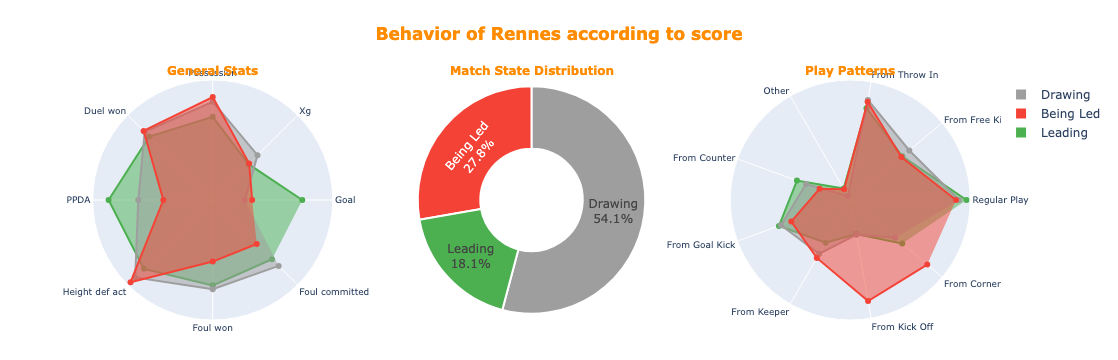

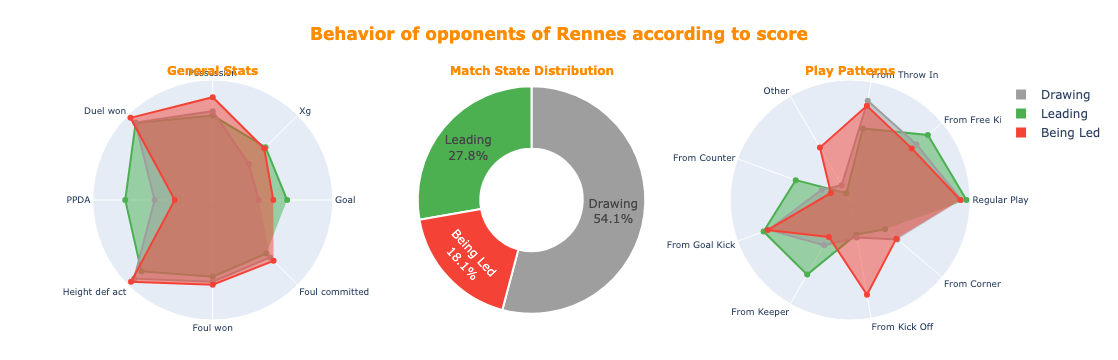


What would you like to do?
1. Show team dashboard only
2. Show opponent dashboard only
3. Show both dashboards
4. Save full dashboards as PDF
5. Choose another team
6. Exit
👉 Enter your choice (1-6):  4


✅ Both dashboards saved successfully in the 'charts' folder.



What would you like to do?
1. Show team dashboard only
2. Show opponent dashboard only
3. Show both dashboards
4. Save full dashboards as PDF
5. Choose another team
6. Exit
👉 Enter your choice (1-6):  6


👋 Bye!


In [79]:
# Importing libraries
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# Team selection
def choose_team(csv_path='table/table_team.csv'):
    try:
        df = pd.read_csv(csv_path)
        if 'team_name' not in df.columns:
            print("❌ The 'team_name' column was not found in the file.")
            return None, None
        teams = sorted(df['team_name'].dropna().unique())
        print("\n🔍 Ligue 1 15/16 season teams:")
        for idx, team in enumerate(teams, 1):
            print(f"{idx}. {team}")
        while True:
            choice = input("\n👉 Enter the number of the team you want to analyze: ")
            if choice.isdigit():
                choice = int(choice)
                if 1 <= choice <= len(teams):
                    selected_team = teams[choice - 1]
                    return selected_team, df
            print("❗ Invalid input. Please enter a valid number.")
    except FileNotFoundError:
        print(f"❌ File '{csv_path}' not found.")
        return None, None
    except Exception as e:
        print(f"❌ An error occurred: {e}")
        return None, None

# Create dashboard for a dataset
def build_dashboard(team_name, df, title):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Statistics and status list
    base_categories = ['goal', 'xg', 'poss', 'duel_won', 'ppda', 'height_def_act', 'foul_won', 'foul_com']
    play_categories = ['regular_play', 'from_free_kick', 'from_throw_in', 'other',
                       'from_counter', 'from_goal_kick', 'from_keeper', 'from_kick_off', 'from_corner']
    match_states = ['lead', 'draw', 'loose']

    # Retrieve team information
    team_data = df[df['team_name'] == team_name]

    # Pie chart values in floating
    lead = float(team_data['lead_prop'])
    draw = float(team_data['draw_prop'])
    loose = float(team_data['loose_prop'])
    pie_labels = ['Leading', 'Drawing', 'Being Led'] # State
    pie_values = [lead, draw, loose]
    pie_colors = ['#4CAF50', '#9E9E9E', '#F44336'] # Green, grey, red

    # Normalize base_categories
    radar_data = {state: [] for state in match_states}
    real_radar_data = {state: [] for state in match_states}
    for base in base_categories:
        # Maximum value recovery by category
        max_value = df[[f"lead_{base}", f"draw_{base}", f"loose_{base}"].copy()].max().max()
        for state in match_states:
            raw_val = float(team_data[f"{state}_{base}"]) # Float
            norm_val = raw_val / max_value if max_value != 0 else 0 # Normalization
            radar_data[state].append(norm_val)
            real_radar_data[state].append(raw_val)
    
    # List of labels for Radar 1
    radar_labels = ['Goal', 'Xg', 'Possession', 'Duel won', 'PPDA', 'Height def act', 'Foul won', 'Foul committed']

    # Normalize play_patterns
    radar_data_phase = {state: [] for state in match_states}
    real_radar_data_phase = {state: [] for state in match_states}
    radar_labels_phase = [x.replace('_', ' ').title() for x in play_categories]
    for base in play_categories:
        # Maximum value recovery by category
        max_value = df[[f"lead_{base}", f"draw_{base}", f"loose_{base}"].copy()].max().max()
        for state in match_states:
            val = float(team_data[f"{state}_{base}"]) # Float
            radar_data_phase[state].append(val / max_value if max_value != 0 else 0)
            real_radar_data_phase[state].append(val)

    # Create figure with 3 subplots
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'polar'}, {'type': 'domain'}, {'type': 'polar'}]],
        column_widths=[0.35, 0.3, 0.35],
        horizontal_spacing=0.08,
        subplot_titles=["General Stats", "Match State Distribution", "Play Patterns"] # Name of charts
    )

    # Color subplot titles
    for annotation in fig['layout']['annotations']:
        annotation['text'] = f"<b>{annotation['text']}</b>"
        annotation['font'] = dict(color='#FF8C00')

    # Pie Chart
    fig.add_trace(go.Pie(
        labels=pie_labels,
        values=pie_values,
        marker=dict(colors=pie_colors, line=dict(color='white', width=2)),
        hovertemplate='%{label}<br> %{value:.1f}%<extra></extra>', # Title in bold
        textinfo='label+percent',
        hole=0.45,
        showlegend=True
    ), row=1, col=2)

    # Radar 1: General Stats
    for state, color in zip(match_states, ['#4CAF50', '#9E9E9E', '#F44336']): # Green, Grey, Red
        fig.add_trace(go.Scatterpolar(
            r=radar_data[state],
            theta=radar_labels,
            fill='toself',
            mode='lines',
            name=state.capitalize(),
            line=dict(color=color),
            hoverinfo='skip',
            showlegend=False
        ), row=1, col=1)

        fig.add_trace(go.Scatterpolar(
            r=radar_data[state],
            theta=radar_labels,
            mode='markers',
            marker=dict(size=6, color=color),
            customdata=[[v] for v in real_radar_data[state]],
            hovertemplate='%{theta}<br> %{customdata[0]:.2f}<extra></extra>',
            name='',
            showlegend=False
        ), row=1, col=1)

    # Radar 2: Play Patterns
    for state, color in zip(match_states, ['#4CAF50', '#9E9E9E', '#F44336']):
        fig.add_trace(go.Scatterpolar(
            r=radar_data_phase[state],
            theta=radar_labels_phase,
            fill='toself',
            mode='lines',
            line=dict(color=color),
            name='',
            hoverinfo='skip',
            showlegend=False
        ), row=1, col=3)

        fig.add_trace(go.Scatterpolar(
            r=radar_data_phase[state],
            theta=radar_labels_phase,
            mode='markers',
            marker=dict(size=6, color=color),
            customdata=[[v] for v in real_radar_data_phase[state]],
            hovertemplate='%{theta}<br> %{customdata[0]:.2f}<extra></extra>',
            name='',
            showlegend=False
        ), row=1, col=3)

    # Final layout settings
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", x=0.5, font=dict(color='#FF8C00')), # Dark orange
        polar=dict(
            radialaxis=dict(visible=False),
            angularaxis=dict(visible=True, tickfont=dict(size=9))
        ),
        polar2=dict(
            radialaxis=dict(visible=False),
            angularaxis=dict(visible=True, tickfont=dict(size=9))
        ),
        showlegend=True,
        height=700,
        margin=dict(t=80, b=40)
    )

    return fig

# Main loop with options
def main():

    # Create 'charts' folder if it doesn't exist
    os.makedirs("charts", exist_ok=True)

    while True:
        # Prompt user to choose a team
        team, _ = choose_team()
        if not team:
            break

        # Load data for the selected team and opponents
        df_team = pd.read_csv('table/table_team.csv')
        df_against = pd.read_csv('table/table_against_team.csv')

        # Build dashboards for the team and for its opponents
        fig1 = build_dashboard(team, df_team, f"Behavior of {team} according to score")
        fig2 = build_dashboard(team, df_against, f"Behavior of opponents of {team} according to score")

        while True:
            # Show action menu
            next_action = input(
                "\nWhat would you like to do?\n"
                "1. Show team dashboard only\n"
                "2. Show opponent dashboard only\n"
                "3. Show both dashboards\n"
                "4. Save full dashboards as PDF\n"
                "5. Choose another team\n"
                "6. Exit\n"
                "👉 Enter your choice (1-6): "
            )

            if next_action == '1':
                fig1.show()
            elif next_action == '2':
                fig2.show()
            elif next_action == '3':
                fig1.show()
                fig2.show()
            elif next_action == '4':
                try:
                    # Save both dashboards in the 'Charts' folder
                    fig1.write_image(f"charts/{team}_team_dashboard.pdf", width=1000, height=700)
                    fig2.write_image(f"charts/{team}_opponents_dashboard.pdf", width=1000, height=700)
                    print("✅ Both dashboards saved successfully in the 'charts' folder.")
                except Exception as e:
                    print(f"❌ Export failed: {e}")
            elif next_action == '5':
                break  # Back to team selection
            elif next_action == '6':
                print("👋 Bye!")
                return
            else:
                print("❗ Invalid input. Please choose a valid option.")




# Run the app
main()